In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [136]:
data = pd.read_csv('cleaned_data/agg_us_holdings.csv')
data["date_holding"] = pd.to_datetime(data["date_holding"])
data["date_filed"] = pd.to_datetime(data["date_filed"])

In [137]:
data.head()

,cik,date_holding,date_filed,ticker,num_shares,buy_price,sell_price,value,quarter_return
0,886982,1999-12-31,2000-02-14,SRT,35000,28.74,58.32,"1,005,835.44",1.03
1,854157,1999-12-31,2000-01-28,RCMT,246000,6.03,4.37,"1,482,907.44",-0.28
2,854157,1999-12-31,2000-01-28,RF,20000,10.16,9.36,"203,231.91",-0.08
3,854157,1999-12-31,2000-01-28,RHI,170000,10.38,17.24,"1,765,052.67",0.66
4,854157,1999-12-31,2000-01-28,ROK,327400,11.02,9.68,"3,608,587.29",-0.12


# Fund Features

In [4]:
# Fund Size
fund_size = data.groupby(['cik','date_holding']).value.sum()
fund_size.head()

cik   date_holding
2230  2000-03-31      1.021391e+09
      2000-06-30      1.605305e+09
      2000-09-30      2.019415e+09
      2001-06-30      1.764545e+09
      2001-09-30      1.462486e+09
Name: value, dtype: float64

In [5]:
# Absolute returns
tmp = data.copy()
tmp["abs_quarter_return"] = tmp["value"] * tmp["quarter_return"]
abs_return = tmp.groupby(['cik','date_holding']).abs_quarter_return.sum()
abs_return.head()

cik   date_holding
2230  2000-03-31      1.687056e+07
      2000-06-30      8.980155e+07
      2000-09-30     -1.454557e+08
      2001-06-30     -2.713935e+08
      2001-09-30      1.045518e+08
Name: abs_quarter_return, dtype: float64

In [6]:
# Fund inflow
fund_size_before_flow = (fund_size + abs_return
                        ).reset_index(level=0).groupby('cik').shift(periods=1,freq="Q"
                                                                   ).reset_index().set_index(['cik','date_holding']
                                                                                            ).iloc[:,0]
fund_inflow = (fund_size - fund_size_before_flow) / fund_size_before_flow
fund_inflow.head()

cik   date_holding
2230  2000-03-31           NaN
      2000-06-30      0.546147
      2000-09-30      0.191320
      2000-12-31           NaN
      2001-06-30           NaN
dtype: float64

In [7]:
# Fund quarter return
fund_return = abs_return / fund_size
fund_return.head()

cik   date_holding
2230  2000-03-31      0.016517
      2000-06-30      0.055940
      2000-09-30     -0.072029
      2001-06-30     -0.153804
      2001-09-30      0.071489
dtype: float64

In [8]:
# Fund age (number of quarters)
def get_fund_age(series):
    series["fund_age"] = (series.date_holding.dt.year-series.date_holding.min().year)*4+(
        series.date_holding.dt.quarter-series.date_holding.min().quarter)
    return series.reset_index(drop=True).set_index('date_holding').fund_age

fund_age = fund_size.reset_index(level=1).drop(columns="value").sort_values('date_holding').groupby('cik').apply(get_fund_age)
fund_age.head()

cik   date_holding
2230  2000-03-31      0
      2000-06-30      1
      2000-09-30      2
      2001-06-30      5
      2001-09-30      6
Name: fund_age, dtype: int64

In [10]:
cik_dates_map = data.groupby('cik').date_holding.unique().apply(list).to_dict()

In [12]:
from tqdm import tqdm
tqdm.pandas()

def get_shares_diff(df):
    curr_quarter = df.set_index('date_holding').num_shares
    # Assume not holding in previous quarter
    prev_quarter = curr_quarter.shift(periods=1,freq="Q").reindex(curr_quarter.index).fillna(0)
    return curr_quarter - prev_quarter


shares_diff = data.groupby(['cik','ticker']).progress_apply(get_shares_diff)

100%|██████████| 3496792/3496792 [1:50:43<00:00, 526.32it/s]


In [13]:
def get_turnover(df):
    # Number of shares difference multiplied by the price during the rebalance to get value that was turned over
    df["turnover"] = df.num_shares * df.buy_price
    turnover_bought = df[df.turnover > 0].turnover.sum()
    turnover_sold = abs(df[df.turnover < 0].turnover.sum())
    return min(turnover_bought,turnover_sold)

turnover = shares_diff.reset_index().merge(data[["cik","ticker","date_holding","buy_price"]],
                                           on=["cik","ticker","date_holding"]
                                          ).groupby(['cik','date_holding']).apply(get_turnover)

# columns with no previous quarter filing should have turnover replaced with NaN
turnover = turnover.where(turnover.index.map(lambda x:(x[1] - pd.tseries.offsets.QuarterEnd()) in cik_dates_map[x[0]]), np.NaN)

In [544]:
fund_features = pd.DataFrame({"size":fund_size,
                              "age": fund_age,
                              "inflow": fund_inflow,
                              "return": fund_return, 
                              "turnover":turnover}).dropna(how="all").reset_index().set_index(['date_holding','cik']).sort_index()
fund_features["turnover_ratio"] = fund_features["turnover"] / fund_features["size"]

In [545]:
# Add expanding features, with minimum 4 past points for the expanding window
def add_expanding_features(df):
    # Lag all expanding features as they are forward looking
    # Use feature calculated for next available filing instead of current filing
    df["avg_inflow"] =  df.expanding(4).inflow.mean().shift(1)
    df["cum_annual_return"] =  df.expanding(4)["return"].apply(lambda x: (np.prod(1+x) ** (4/x.notna().sum())) - 1).shift(1)
    df["annual_volatility"] =  (df.expanding(4)["return"].std() * 2).shift(1)
    df["avg_turnover_ratio"] =  df.expanding(4).turnover_ratio.mean().shift(1)
    return df

fund_features = fund_features.groupby('cik').apply(add_expanding_features)

C:\Users\ohste\AppData\Local\Temp\ipykernel_42584\3594205221.py:11: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  fund_features = fund_features.groupby('cik').apply(add_expanding_features)


In [546]:
fund_features = fund_features.drop(columns=["inflow", "turnover", "turnover_ratio"]).dropna().rename(columns={"return":"next_quarter_return"})

In [547]:
fund_features

size  age  next_quarter_return  avg_inflow  \
date_holding cik                                                           
2001-06-30   35527    6.374831e+09  6.0            -0.139785    0.143821   
             36644    2.453778e+08  6.0            -0.134640    0.067495   
             71210    7.554694e+08  6.0            -0.146712    0.090803   
             99782    1.374074e+10  6.0             0.028187    0.239835   
             201870   2.692100e+10  6.0            -0.273841   -0.025610   
...                            ...  ...                  ...         ...   
2022-03-31   1846161  1.488938e+08  5.0            -0.139855    0.083918   
             1846177  1.056996e+08  5.0            -0.120979    0.543915   
             1846311  7.683533e+08  5.0            -0.168980    0.100517   
             1846352  1.690770e+08  5.0            -0.193983    0.027179   
             1846368  4.282524e+07  5.0            -0.190111    1.098576   

                      cum_annual_return  annual_volatility  avg_turnover_ratio  
date_holding cik                                                                
2001-06-30   35527            -0.148144           0.175085            0.060435  
             36644            -0.139813           0.094799            0.070095  
             71210            -0.062658           0.189850            0.012497  
             99782            -0.233263           0.501972            0.039491  
             201870           -0.320777           0.445484            0.167699  
...                                 ...                ...                 ...  
2022-03-31   1846161           0.142758           0.102290            0.052025  
             1846177           0.165919           0.114783            0.166465  
             1846311           0.068480           0.152768            0.024502  
             1846352           0.153061           0.161791            0.051436  
             1846368          -0.042775           0.208609            0.033285  

[166660 rows x 7 columns]

In [637]:
fund_features.to_csv('cleaned_data/fund_features.csv')

# Fund Level Snapshot Analysis

In [18]:
fund_features = pd.read_csv('cleaned_data/fund_features.csv',index_col=[0,1])

In [19]:
fund_features

size  age  next_quarter_return  avg_inflow  \
date_holding cik                                                           
2001-06-30   35527    6.374831e+09  6.0            -0.139785    0.143821   
             36644    2.453778e+08  6.0            -0.134640    0.067495   
             71210    7.554694e+08  6.0            -0.146712    0.090803   
             99782    1.374074e+10  6.0             0.028187    0.239835   
             201870   2.692100e+10  6.0            -0.273841   -0.025610   
...                            ...  ...                  ...         ...   
2022-03-31   1846161  1.488938e+08  5.0            -0.139855    0.083918   
             1846177  1.056996e+08  5.0            -0.120979    0.543915   
             1846311  7.683533e+08  5.0            -0.168980    0.100517   
             1846352  1.690770e+08  5.0            -0.193983    0.027179   
             1846368  4.282524e+07  5.0            -0.190111    1.098576   

                      cum_annual_return  annual_volatility  avg_turnover_ratio  
date_holding cik                                                                
2001-06-30   35527            -0.148144           0.175085            0.060435  
             36644            -0.139813           0.094799            0.070095  
             71210            -0.062658           0.189850            0.012497  
             99782            -0.233263           0.501972            0.039491  
             201870           -0.320777           0.445484            0.167699  
...                                 ...                ...                 ...  
2022-03-31   1846161           0.142758           0.102290            0.052025  
             1846177           0.165919           0.114783            0.166465  
             1846311           0.068480           0.152768            0.024502  
             1846352           0.153061           0.161791            0.051436  
             1846368          -0.042775           0.208609            0.033285  

[166660 rows x 7 columns]

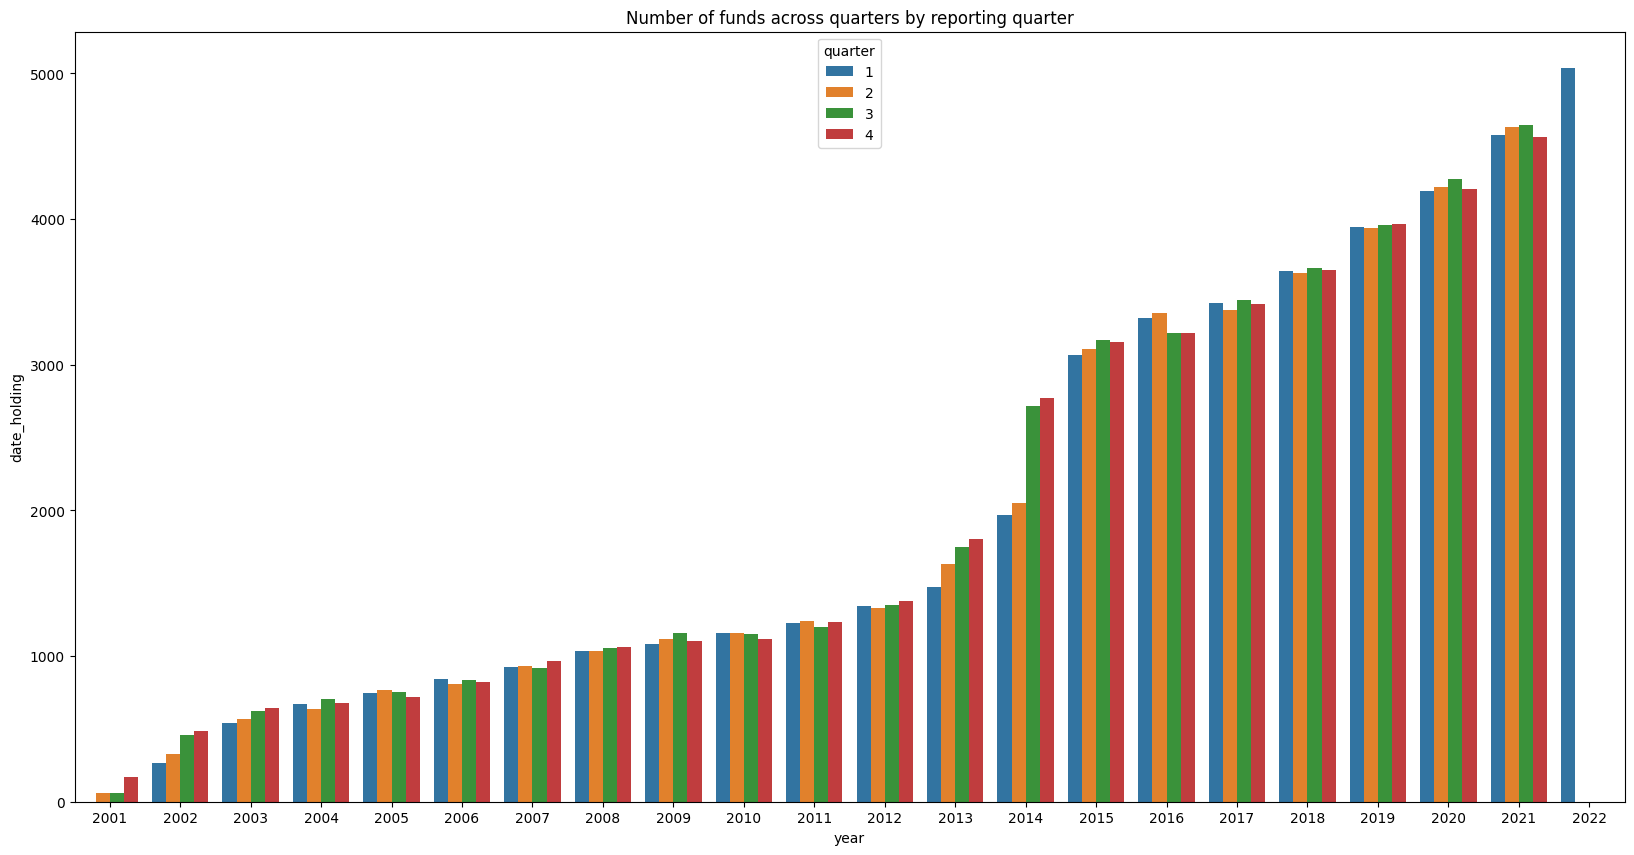

In [20]:
# Poor quality of data before 2002
comp_count = fund_features.reset_index().date_holding.value_counts().reset_index().rename(columns={"index":"date"})
comp_count["year"] = pd.to_datetime(comp_count.date).dt.year
comp_count["quarter"] = pd.to_datetime(comp_count.date).dt.quarter
plt.figure(figsize=(20,10))
ax = sns.barplot(x="year", y="date_holding",hue="quarter", data=comp_count)
plt.title("Number of funds across quarters by reporting quarter")
plt.show()

In [21]:
# Null values coming from lack of past quarter results
fund_features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 166660 entries, ('2001-06-30', 35527) to ('2022-03-31', 1846368)
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   size                 166660 non-null  float64
 1   age                  166660 non-null  float64
 2   next_quarter_return  166660 non-null  float64
 3   avg_inflow           166660 non-null  float64
 4   cum_annual_return    166660 non-null  float64
 5   annual_volatility    166660 non-null  float64
 6   avg_turnover_ratio   166660 non-null  float64
dtypes: float64(7)
memory usage: 9.7+ MB


In [22]:
fund_features.describe()

,size,age,next_quarter_return,avg_inflow,cum_annual_return,annual_volatility,avg_turnover_ratio
count,1.666600e+05,166660.000000,166660.000000,1.666600e+05,166660.000000,166660.000000,166660.000000
mean,8.516795e+15,29.602904,0.013978,4.997109e+06,0.021621,0.252715,0.057354
std,9.295045e+17,20.199551,0.146733,2.358865e+08,0.165411,0.166631,1.179388
min,-4.775236e+09,5.000000,-0.998683,-1.707839e+02,-0.994373,0.012656,0.000000
25%,1.010619e+08,13.000000,-0.039209,6.080623e-03,-0.047258,0.160807,0.020320
50%,2.917819e+08,24.000000,0.027613,5.359287e-02,0.040197,0.214867,0.037853
75%,1.224932e+09,41.000000,0.080674,2.535874e-01,0.109613,0.298152,0.069654
max,2.312104e+20,89.000000,5.847203,2.858997e+10,4.184282,9.215774,298.687953


In [121]:
# look at train data (before 2018)
# Question: any issues if observations repeated for same funds?
train_fund_features = fund_features.loc[:"2018-12-31"]

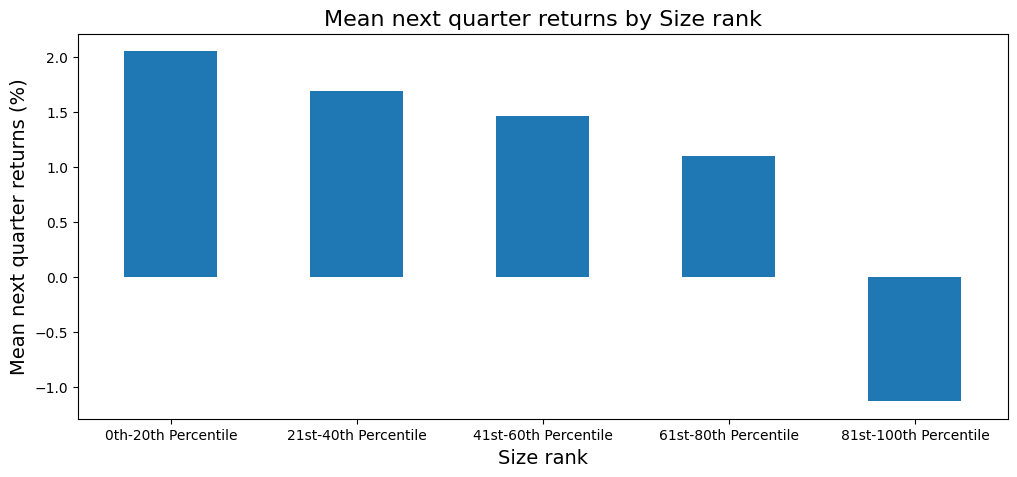

In [122]:
# Barplot based on category of size 
# Larger size funds have smaller returns
tmp = train_fund_features.copy()
tmp["size_rank"] = tmp.groupby("date_holding")["size"].rank(pct=True)
tmp["size_group"] = tmp["size_rank"].apply(lambda x: int(x/0.2)).clip(upper=4)
plt.figure(figsize=(12,5))
(tmp.groupby('size_group')["next_quarter_return"].mean() * 100).plot(kind="bar")
plt.title("Mean next quarter returns by Size rank",fontsize=16)
plt.xlabel("Size rank",fontsize=14)
plt.ylabel("Mean next quarter returns (%)",fontsize=14)
plt.xticks(np.arange(5),labels=["0th-20th Percentile",
                                "21st-40th Percentile",
                                "41st-60th Percentile",
                                "61st-80th Percentile",
                                "81st-100th Percentile"], rotation=0)
print()

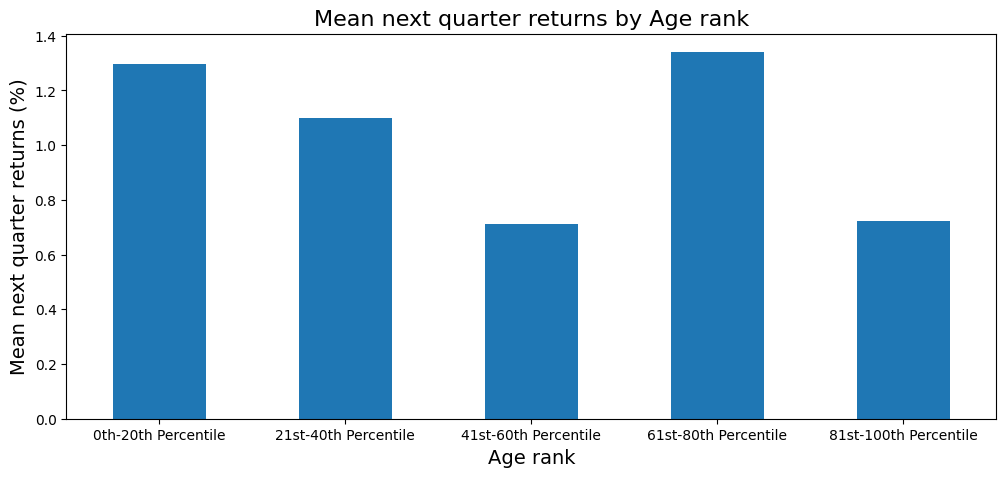

In [123]:
# Barplot based on category of age 
tmp = train_fund_features.copy()
tmp["age_rank"] = tmp.groupby("date_holding")["age"].rank(pct=True)
tmp["age_group"] = tmp["age_rank"].apply(lambda x: int(x/0.2)).clip(upper=4)
plt.figure(figsize=(12,5))
(tmp.groupby('age_group')["next_quarter_return"].mean() * 100).plot(kind="bar")
plt.title("Mean next quarter returns by Age rank",fontsize=16)
plt.xlabel("Age rank",fontsize=14)
plt.ylabel("Mean next quarter returns (%)",fontsize=14)
plt.xticks(np.arange(5),labels=["0th-20th Percentile",
                                "21st-40th Percentile",
                                "41st-60th Percentile",
                                "61st-80th Percentile",
                                "81st-100th Percentile"], rotation=0)
print()

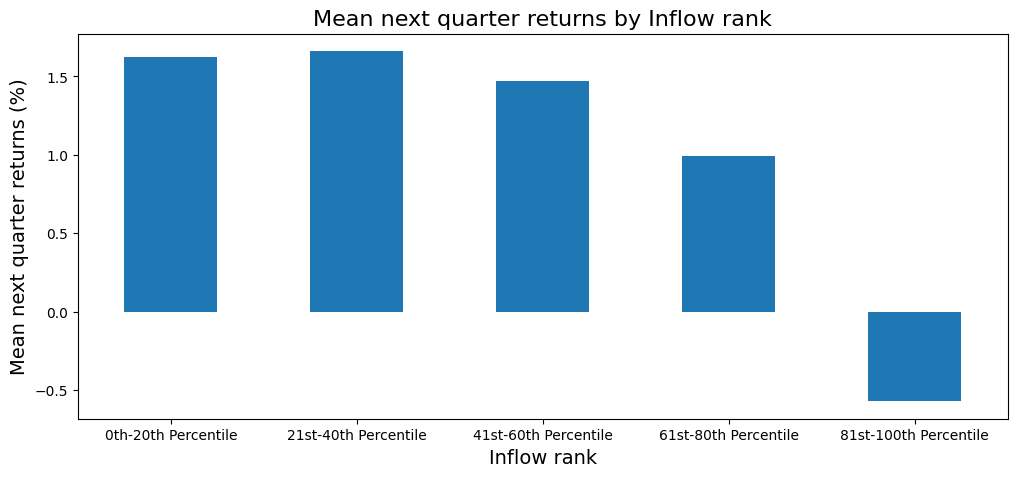

In [124]:
# Barplot based on category of inflow 
# Funds with the largest inflow have negative returns
tmp = train_fund_features.copy()
tmp["inflow_rank"] = tmp.groupby("date_holding")["avg_inflow"].rank(pct=True)
tmp["inflow_group"] = tmp["inflow_rank"].apply(lambda x: int(x/0.2)).clip(upper=4)
plt.figure(figsize=(12,5))
(tmp.groupby('inflow_group')["next_quarter_return"].mean()*100).plot(kind="bar")
plt.title("Mean next quarter returns by Inflow rank",fontsize=16)
plt.xlabel("Inflow rank",fontsize=14)
plt.ylabel("Mean next quarter returns (%)",fontsize=14)
plt.xticks(np.arange(5),labels=["0th-20th Percentile",
                                "21st-40th Percentile",
                                "41st-60th Percentile",
                                "61st-80th Percentile",
                                "81st-100th Percentile"], rotation=0)
print()

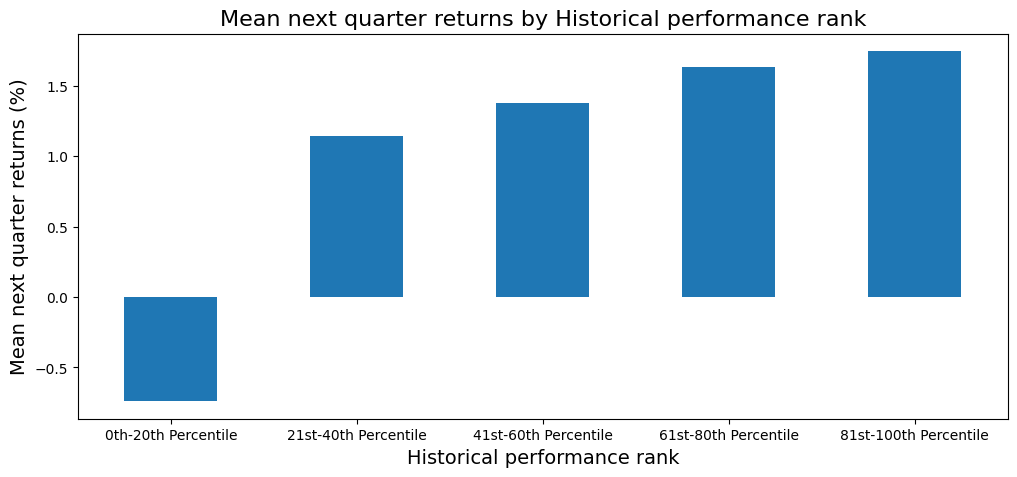

In [125]:
# Barplot based on category of historical return
# Funds with better historical performance give better returns
tmp = train_fund_features.copy()
tmp["return_rank"] = tmp.groupby("date_holding")["cum_annual_return"].rank(pct=True)
tmp["return_group"] = tmp["return_rank"].apply(lambda x: int(x/0.2)).clip(upper=4)
plt.figure(figsize=(12,5))
(tmp.groupby('return_group')["next_quarter_return"].mean()*100).plot(kind="bar")
plt.title("Mean next quarter returns by Historical performance rank",fontsize=16)
plt.xlabel("Historical performance rank",fontsize=14)
plt.ylabel("Mean next quarter returns (%)",fontsize=14)
plt.xticks(np.arange(5),labels=["0th-20th Percentile",
                                "21st-40th Percentile",
                                "41st-60th Percentile",
                                "61st-80th Percentile",
                                "81st-100th Percentile"], rotation=0)
print()

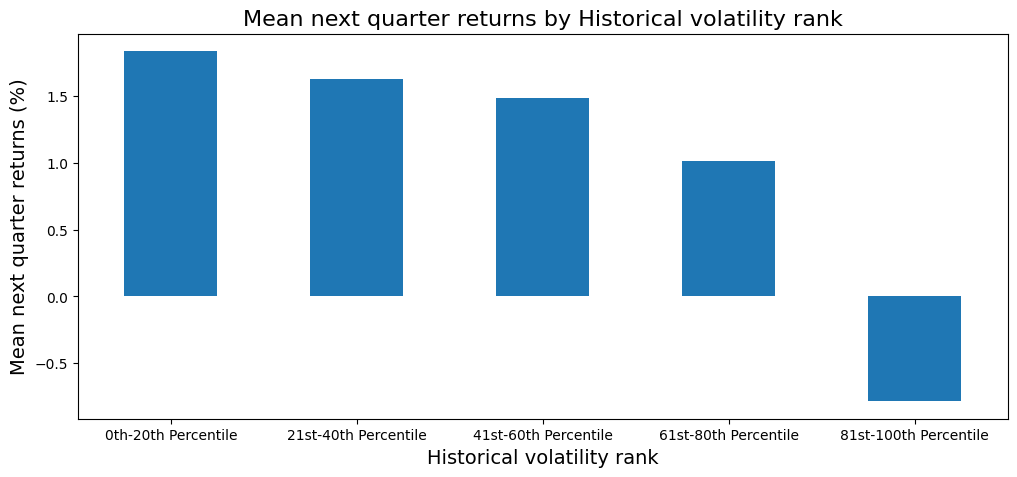

In [126]:
# Barplot based on category of volatility 
# Funds with higher volatility lead to lower returns 
tmp = train_fund_features.copy()
tmp["vol_rank"] = tmp.groupby("date_holding")["annual_volatility"].rank(pct=True)
tmp["vol_group"] = tmp["vol_rank"].apply(lambda x: int(x/0.2)).clip(upper=4)
plt.figure(figsize=(12,5))
(tmp.groupby('vol_group')["next_quarter_return"].mean()*100).plot(kind="bar")
plt.title("Mean next quarter returns by Historical volatility rank",fontsize=16)
plt.xlabel("Historical volatility rank",fontsize=14)
plt.ylabel("Mean next quarter returns (%)",fontsize=14)
plt.xticks(np.arange(5),labels=["0th-20th Percentile",
                                "21st-40th Percentile",
                                "41st-60th Percentile",
                                "61st-80th Percentile",
                                "81st-100th Percentile"], rotation=0)
print()

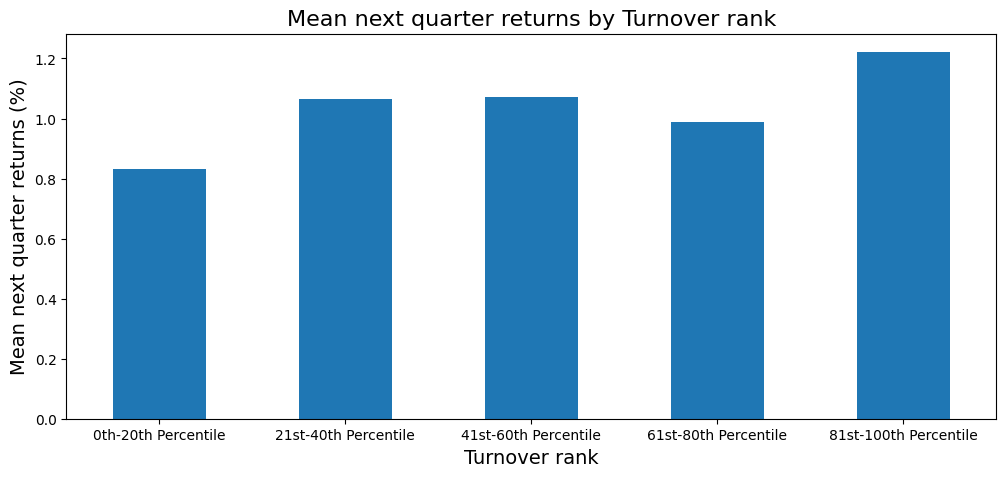

In [127]:
# Barplot based on category of turnover ratio  
# No clear relationship between turnover and future returns
tmp = train_fund_features.copy()
tmp["turnover_ratio_rank"] = tmp.groupby("date_holding")["avg_turnover_ratio"].rank(pct=True)
tmp["turnover_ratio_group"] = tmp["turnover_ratio_rank"].apply(lambda x: int(x/0.2)).clip(upper=4)
plt.figure(figsize=(12,5))
(tmp.groupby('turnover_ratio_group')["next_quarter_return"].mean()*100).plot(kind="bar")
plt.title("Mean next quarter returns by Turnover rank",fontsize=16)
plt.xlabel("Turnover rank",fontsize=14)
plt.ylabel("Mean next quarter returns (%)",fontsize=14)
plt.xticks(np.arange(5),labels=["0th-20th Percentile",
                                "21st-40th Percentile",
                                "41st-60th Percentile",
                                "61st-80th Percentile",
                                "81st-100th Percentile"], rotation=0)
print()

<AxesSubplot: >

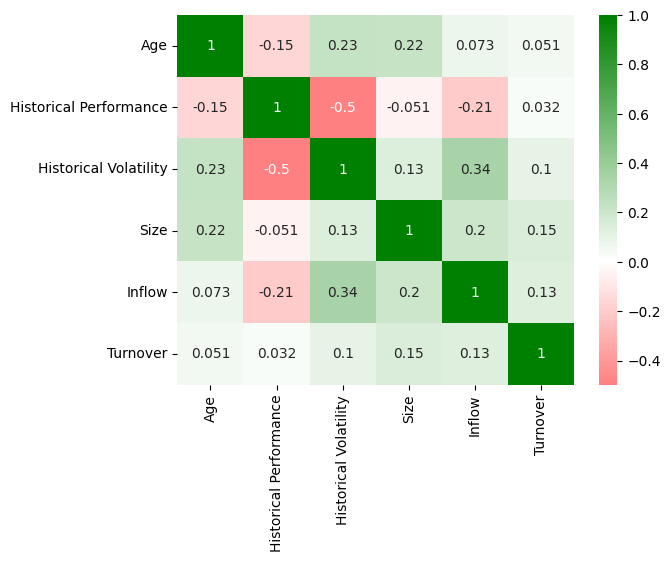

In [128]:
# Fund volatility negatively correlated with historical returns
# Fund volatility positively correlated with inflow

from matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
tmp = train_fund_features[["age","cum_annual_return","annual_volatility","size","avg_inflow","avg_turnover_ratio"]]
tmp.columns = ["Age", "Historical Performance", "Historical Volatility", "Size", "Inflow", "Turnover"]
sns.heatmap(tmp.corr(method="spearman"), annot=True, cmap=cmap, center=0)

<AxesSubplot: >

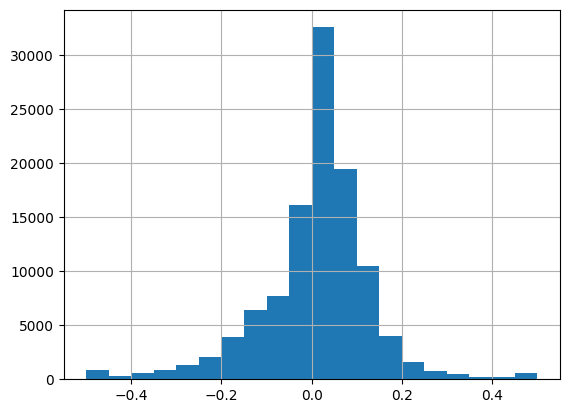

In [129]:
# Will splitting by subfund show a different distribution or different insights?
train_fund_features.next_quarter_return.clip(lower=-0.5,upper=0.5).hist(bins=20)

# Subfund Features

In [138]:
ticker_meta = pd.read_csv('raw_data/ticker_meta.csv')

In [139]:
sector_data = data.merge(ticker_meta[["ticker", "sector"]].drop_duplicates(), on="ticker")
sector_data = sector_data.dropna(subset=["sector"])
sector_data["cik_sector"] = sector_data["cik"].apply(str) + "-" + sector_data["sector"]
sector_data = sector_data.drop(columns=["cik","sector"]).set_index("cik_sector").reset_index()


KeyboardInterrupt



In [ ]:
sector_data.head()

In [ ]:
# Fund Size
subfund_size = sector_data.groupby(['cik_sector','date_holding']).value.sum()
subfund_size.head()

In [ ]:
# Absolute returns
tmp = sector_data.copy()
tmp["abs_quarter_return"] = tmp["value"] * tmp["quarter_return"]
subfund_abs_return = tmp.groupby(['cik_sector','date_holding']).abs_quarter_return.sum()
subfund_abs_return.head()

In [ ]:
# Fund inflow
subfund_size_before_flow = (subfund_size + subfund_abs_return
                        ).reset_index(level=0).groupby('cik_sector').shift(periods=1,freq="Q"
                                                                   ).reset_index().set_index(['cik_sector','date_holding']
                                                                                            ).iloc[:,0]
subfund_inflow = (subfund_size - subfund_size_before_flow) / subfund_size_before_flow
subfund_inflow.head()

In [ ]:
# Fund quarter return
subfund_return = subfund_abs_return / subfund_size
subfund_return.head()

In [ ]:
# Fund age (number of quarters)
def get_fund_age(series):
    series["fund_age"] = (series.date_holding.dt.year-series.date_holding.min().year)*4+(
        series.date_holding.dt.quarter-series.date_holding.min().quarter)
    return series.reset_index(drop=True).set_index('date_holding').fund_age

subfund_age = subfund_size.reset_index(level=1).drop(columns="value").sort_values('date_holding').groupby('cik_sector').apply(get_fund_age)
subfund_age.head()

In [ ]:
cik_sector_dates_map = sector_data.groupby('cik_sector').date_holding.unique().apply(list).to_dict()

In [ ]:
subfund_shares_diff = shares_diff.reset_index().merge(ticker_meta[["ticker", "sector"]].drop_duplicates(), on="ticker")
subfund_shares_diff = subfund_shares_diff.dropna(subset=["sector"])
subfund_shares_diff["cik_sector"] = subfund_shares_diff["cik"].apply(str) + "-" + subfund_shares_diff["sector"]
subfund_shares_diff = subfund_shares_diff.drop(columns=["cik","sector"]).set_index("cik_sector").reset_index()

In [ ]:
def get_turnover(df):
    # Number of shares difference multiplied by the price during the rebalance to get value that was turned over
    df["turnover"] = df.num_shares * df.buy_price
    turnover_bought = df[df.turnover > 0].turnover.sum()
    turnover_sold = abs(df[df.turnover < 0].turnover.sum())
    return min(turnover_bought,turnover_sold)

subfund_turnover = subfund_shares_diff.reset_index().merge(sector_data[["cik_sector","ticker","date_holding","buy_price"]],
                                           on=["cik_sector","ticker","date_holding"]
                                          ).groupby(['cik_sector','date_holding']).progress_apply(get_turnover)

# columns with no previous quarter filing should have turnover replaced with NaN
subfund_turnover = subfund_turnover.where(
    subfund_turnover.index.map(lambda x:(x[1] - pd.tseries.offsets.QuarterEnd()) in cik_sector_dates_map[x[0]]), np.NaN)

In [ ]:
subfund_features = pd.DataFrame({"size":subfund_size,
                              "age": subfund_age,
                              "inflow": subfund_inflow,
                              "return": subfund_return, 
                              "turnover":subfund_turnover}).dropna(how="all").reset_index().set_index(['date_holding','cik_sector']).sort_index()
subfund_features["turnover_ratio"] = subfund_features["turnover"] / subfund_features["size"]

In [ ]:
# Add expanding features, with minimum 4 past points for the expanding window
def add_expanding_features(df):
    # Lag all expanding features as they are forward looking
    # Use feature calculated for next available filing instead of current filing
    df["avg_inflow"] =  df.expanding(4).inflow.mean().shift(1)
    df["cum_annual_return"] =  df.expanding(4)["return"].apply(lambda x: (np.prod(1+x) ** (4/x.notna().sum())) - 1).shift(1)
    df["annual_volatility"] =  (df.expanding(4)["return"].std() * 2).shift(1)
    df["avg_turnover_ratio"] =  df.expanding(4).turnover_ratio.mean().shift(1)
    return df

subfund_features = subfund_features.groupby('cik_sector').apply(add_expanding_features)

In [563]:
subfund_features = subfund_features.drop(columns=["inflow", "turnover", "turnover_ratio"]).dropna().rename(columns={"return":"next_quarter_return"})

In [564]:
subfund_features

size   age  \
date_holding cik_sector                                           
2001-06-30   1003283-Basic Materials         4.837184e+07   6.0   
             1003283-Communication Services  8.078881e+07   6.0   
             1003283-Consumer Cyclical       1.853369e+08   6.0   
             1003283-Consumer Defensive      4.225997e+08   6.0   
             1003283-Energy                  3.240934e+08   6.0   
...                                                   ...   ...   
2022-03-31   98758-Financial Services        9.557233e+07  65.0   
             98758-Healthcare                8.749099e+07  65.0   
             98758-Industrials               6.170857e+07  65.0   
             98758-Real Estate               1.778309e+06  44.0   
             98758-Technology                1.120067e+08  65.0   

                                             next_quarter_return  avg_inflow  \
date_holding cik_sector                                                        
2001-06-30   1003283-Basic Materials                    0.039614    0.316092   
             1003283-Communication Services            -0.003880   -0.081610   
             1003283-Consumer Cyclical                 -0.225009    0.053028   
             1003283-Consumer Defensive                -0.005060    0.112823   
             1003283-Energy                            -0.294126    0.028805   
...                                                          ...         ...   
2022-03-31   98758-Financial Services                  -0.172586    2.357700   
             98758-Healthcare                          -0.036846    3.446906   
             98758-Industrials                         -0.111134    2.172094   
             98758-Real Estate                         -0.069893    0.459585   
             98758-Technology                          -0.166060    0.477967   

                                             cum_annual_return  \
date_holding cik_sector                                          
2001-06-30   1003283-Basic Materials                 -0.310345   
             1003283-Communication Services          -0.324127   
             1003283-Consumer Cyclical               -0.052652   
             1003283-Consumer Defensive              -0.026727   
             1003283-Energy                           0.136874   
...                                                        ...   
2022-03-31   98758-Financial Services                 0.126446   
             98758-Healthcare                         0.141758   
             98758-Industrials                        0.012183   
             98758-Real Estate                        0.141948   
             98758-Technology                         0.116158   

                                             annual_volatility  \
date_holding cik_sector                                          
2001-06-30   1003283-Basic Materials                  0.186141   
             1003283-Communication Services           0.087189   
             1003283-Consumer Cyclical                0.079873   
             1003283-Consumer Defensive               0.249828   
             1003283-Energy                           0.170673   
...                                                        ...   
2022-03-31   98758-Financial Services                 0.190827   
             98758-Healthcare                         0.153470   
             98758-Industrials                        0.206129   
             98758-Real Estate                        0.157997   
             98758-Technology                         0.172992   

                                             avg_turnover_ratio  
date_holding cik_sector                                          
2001-06-30   1003283-Basic Materials                   0.052965  
             1003283-Communication Services            0.070541  
             1003283-Consumer Cyclical                 0.050337  
             1003283-Consumer Defensive                0.082227  
             1003283-Energ

In [636]:
subfund_features.to_csv('cleaned_data/subfund_features.csv')

# Subfund Level Analysis

In [140]:
subfund_features = pd.read_csv('cleaned_data/subfund_features.csv', index_col=[0,1])

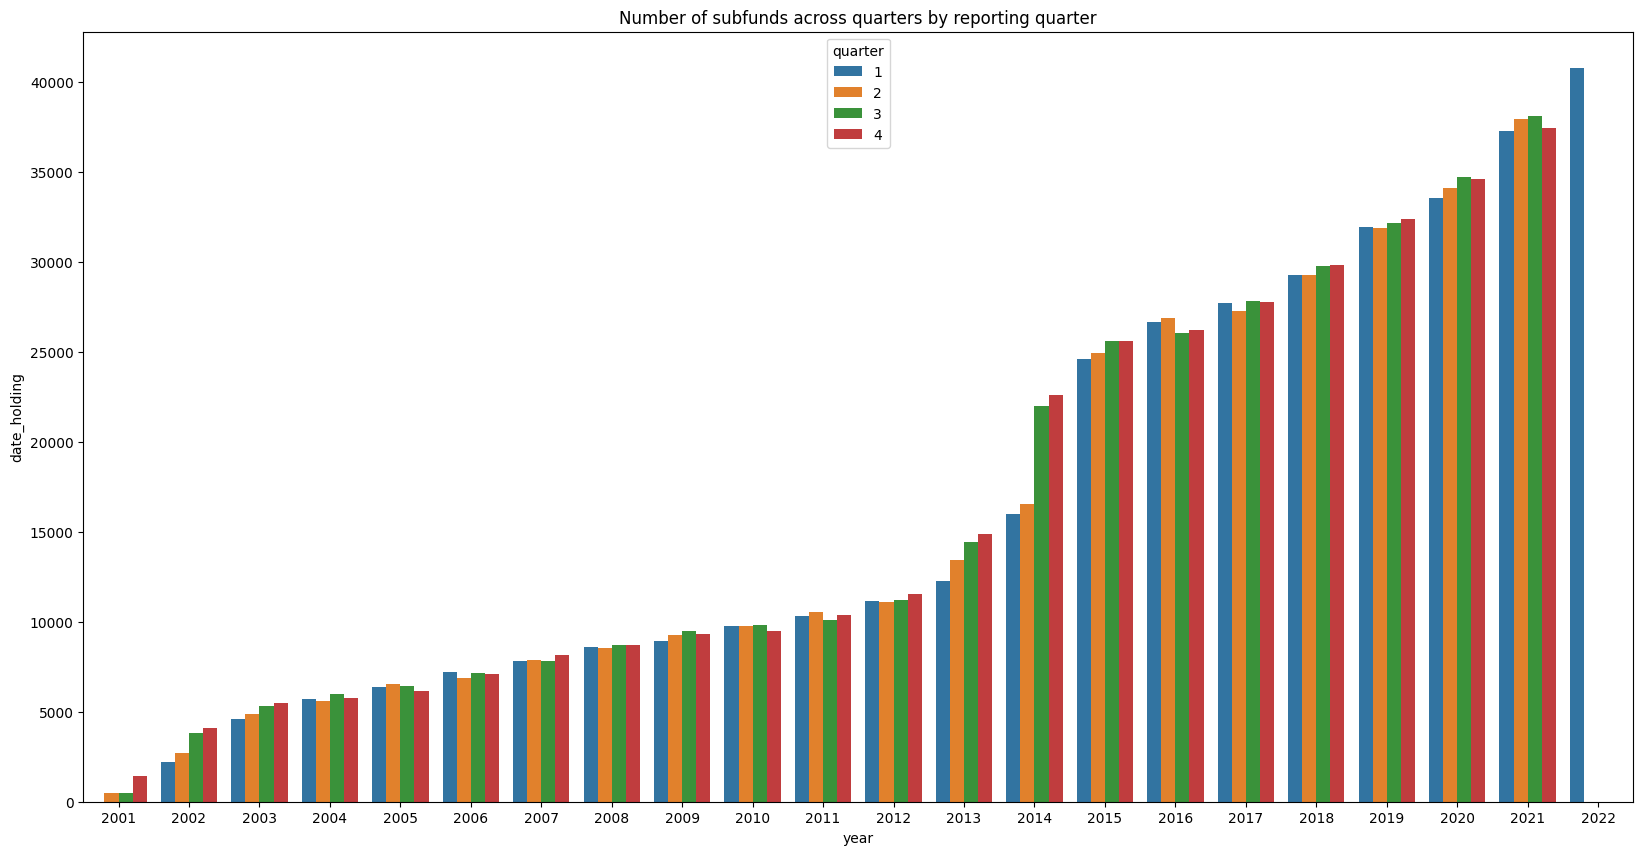

In [566]:
# Poor quality of data before 2002
subfund_count = subfund_features.reset_index().date_holding.value_counts().reset_index().rename(columns={"index":"date"})
subfund_count["year"] = pd.to_datetime(subfund_count.date).dt.year
subfund_count["quarter"] = pd.to_datetime(subfund_count.date).dt.quarter
plt.figure(figsize=(20,10))
ax = sns.barplot(x="year", y="date_holding",hue="quarter", data=subfund_count)
plt.title("Number of subfunds across quarters by reporting quarter")
plt.show()

In [567]:
# Null values coming from lack of past quarter results
subfund_features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1364361 entries, (Timestamp('2001-06-30 00:00:00'), '1003283-Basic Materials') to (Timestamp('2022-03-31 00:00:00'), '98758-Technology')
Data columns (total 7 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   size                 1364361 non-null  float64
 1   age                  1364361 non-null  float64
 2   next_quarter_return  1364361 non-null  float64
 3   avg_inflow           1364361 non-null  float64
 4   cum_annual_return    1364361 non-null  float64
 5   annual_volatility    1364361 non-null  float64
 6   avg_turnover_ratio   1364361 non-null  float64
dtypes: float64(7)
memory usage: 82.1+ MB


In [568]:
subfund_features.describe()

,size,age,next_quarter_return,avg_inflow,cum_annual_return,annual_volatility,avg_turnover_ratio
count,1.364361e+06,1.364361e+06,1.364361e+06,1.364361e+06,1.364361e+06,1.364361e+06,1.364361e+06
mean,1.040107e+15,3.043270e+01,2.211387e-02,3.268376e+06,5.824115e-02,2.486676e-01,3.506636e-02
std,3.248758e+17,2.052218e+01,1.473298e-01,3.793209e+08,1.530837e-01,1.544220e-01,2.210928e-01
min,-4.842879e+09,5.000000e+00,-6.746645e+00,-8.516863e+03,-9.976013e-01,5.171228e-03,-3.121246e+00
25%,5.568487e+06,1.400000e+01,-3.924058e-02,8.542941e-03,-9.100943e-03,1.591537e-01,7.070062e-03
50%,2.330271e+07,2.500000e+01,2.836646e-02,6.752327e-02,6.672260e-02,2.193355e-01,2.026269e-02
75%,1.124416e+08,4.300000e+01,9.015759e-02,2.803023e-01,1.299186e-01,2.981195e-01,4.538171e-02
max,2.312104e+20,8.900000e+01,2.348674e+01,1.271240e+11,1.266982e+01,1.716519e+01,1.493031e+02


In [142]:
# look at train data (before 2018)
# Question: any issues if observations repeated for same funds?
train_subfund_features = subfund_features.loc[:"2018-12-31"]

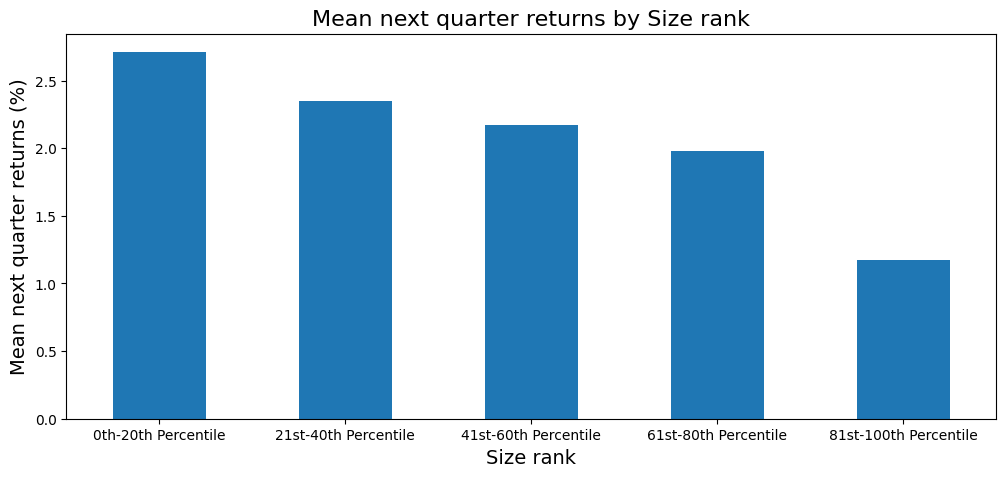

In [149]:
# Barplot based on category of size 
# Larger size funds have smaller returns
tmp = train_subfund_features.copy()
tmp["size_rank"] = tmp.groupby("date_holding")["size"].rank(pct=True)
tmp["size_group"] = tmp["size_rank"].apply(lambda x: int(x/0.2)).clip(upper=4)
plt.figure(figsize=(12,5))
(tmp.groupby('size_group')["next_quarter_return"].mean() * 100).plot(kind="bar")
plt.title("Mean next quarter returns by Size rank",fontsize=16)
plt.xlabel("Size rank",fontsize=14)
plt.ylabel("Mean next quarter returns (%)",fontsize=14)
plt.xticks(np.arange(5),labels=["0th-20th Percentile",
                                "21st-40th Percentile",
                                "41st-60th Percentile",
                                "61st-80th Percentile",
                                "81st-100th Percentile"], rotation=0)
print()

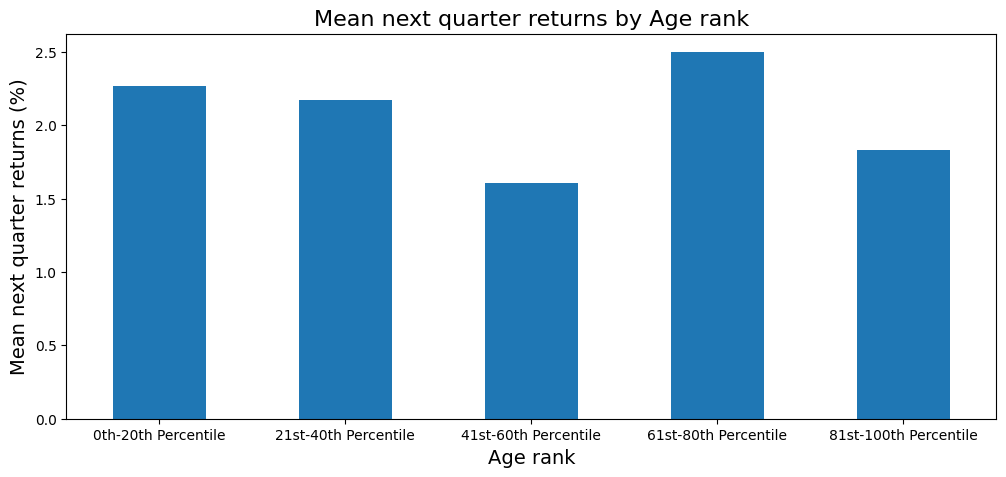

In [150]:
# Barplot based on category of age 
tmp = train_subfund_features.copy()
tmp["age_rank"] = tmp.groupby("date_holding")["age"].rank(pct=True)
tmp["age_group"] = tmp["age_rank"].apply(lambda x: int(x/0.2)).clip(upper=4)
plt.figure(figsize=(12,5))
(tmp.groupby('age_group')["next_quarter_return"].mean() * 100).plot(kind="bar")
plt.title("Mean next quarter returns by Age rank",fontsize=16)
plt.xlabel("Age rank",fontsize=14)
plt.ylabel("Mean next quarter returns (%)",fontsize=14)
plt.xticks(np.arange(5),labels=["0th-20th Percentile",
                                "21st-40th Percentile",
                                "41st-60th Percentile",
                                "61st-80th Percentile",
                                "81st-100th Percentile"], rotation=0)
print()

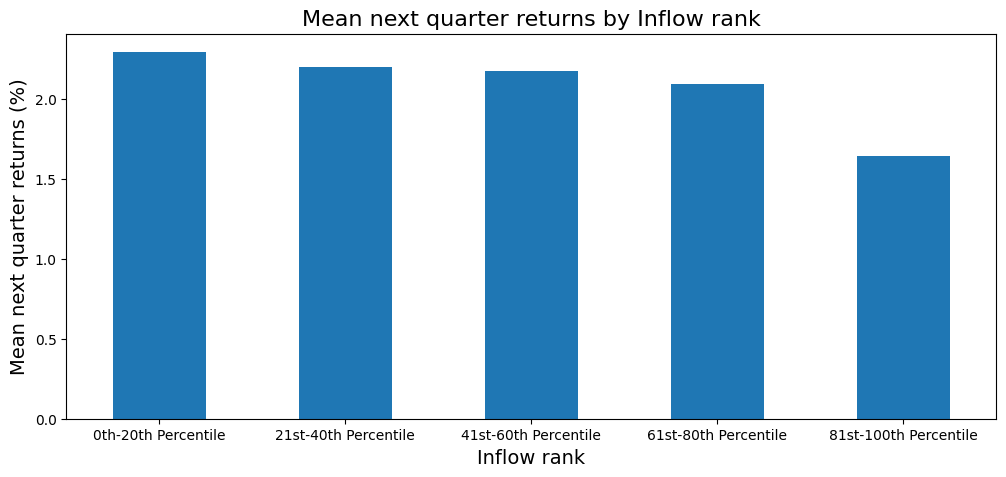

In [151]:
# Barplot based on category of inflow 
# Funds with the largest inflow have smaller returns
tmp = train_subfund_features.copy()
tmp["inflow_rank"] = tmp.groupby("date_holding")["avg_inflow"].rank(pct=True)
tmp["inflow_group"] = tmp["inflow_rank"].apply(lambda x: int(x/0.2)).clip(upper=4)
plt.figure(figsize=(12,5))
(tmp.groupby('inflow_group')["next_quarter_return"].mean()*100).plot(kind="bar")
plt.title("Mean next quarter returns by Inflow rank",fontsize=16)
plt.xlabel("Inflow rank",fontsize=14)
plt.ylabel("Mean next quarter returns (%)",fontsize=14)
plt.xticks(np.arange(5),labels=["0th-20th Percentile",
                                "21st-40th Percentile",
                                "41st-60th Percentile",
                                "61st-80th Percentile",
                                "81st-100th Percentile"], rotation=0)
print()

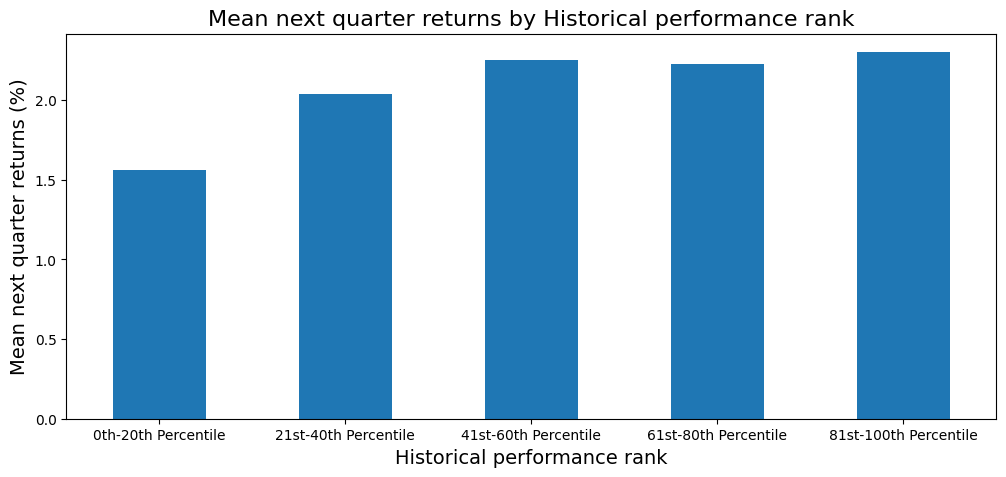

In [152]:
# Barplot based on category of historical return
# Funds with better historical performance give worse returns (contrary to fund analysis)
tmp = train_subfund_features.copy()
tmp["return_rank"] = tmp.groupby("date_holding")["cum_annual_return"].rank(pct=True)
tmp["return_group"] = tmp["return_rank"].apply(lambda x: int(x/0.2)).clip(upper=4)
plt.figure(figsize=(12,5))
(tmp.groupby('return_group')["next_quarter_return"].mean()*100).plot(kind="bar")
plt.title("Mean next quarter returns by Historical performance rank",fontsize=16)
plt.xlabel("Historical performance rank",fontsize=14)
plt.ylabel("Mean next quarter returns (%)",fontsize=14)
plt.xticks(np.arange(5),labels=["0th-20th Percentile",
                                "21st-40th Percentile",
                                "41st-60th Percentile",
                                "61st-80th Percentile",
                                "81st-100th Percentile"], rotation=0)
print()

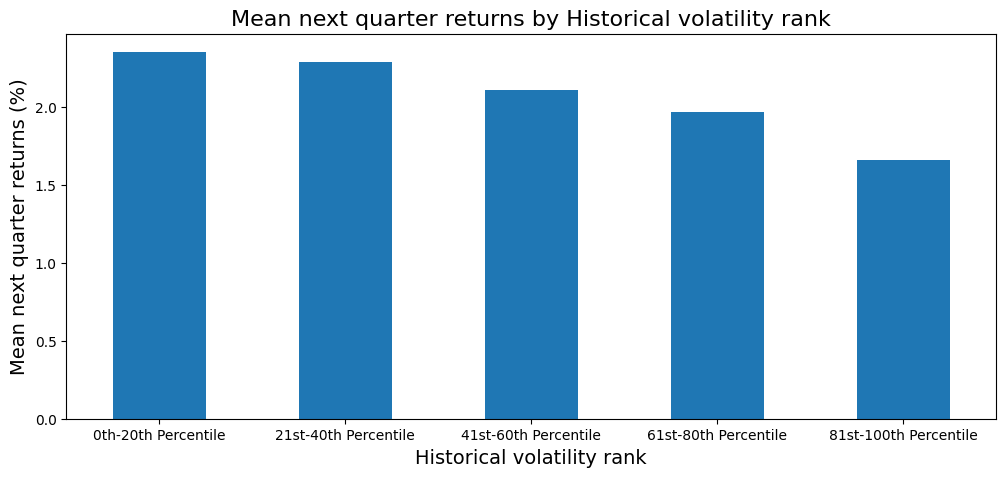

In [153]:
# Barplot based on category of volatility 
# Funds with higher volatility lead to lower returns
tmp = train_subfund_features.copy()
tmp["vol_rank"] = tmp.groupby("date_holding")["annual_volatility"].rank(pct=True)
tmp["vol_group"] = tmp["vol_rank"].apply(lambda x: int(x/0.2)).clip(upper=4)
plt.figure(figsize=(12,5))
(tmp.groupby('vol_group')["next_quarter_return"].mean()*100).plot(kind="bar")
plt.title("Mean next quarter returns by Historical volatility rank",fontsize=16)
plt.xlabel("Historical volatility rank",fontsize=14)
plt.ylabel("Mean next quarter returns (%)",fontsize=14)
plt.xticks(np.arange(5),labels=["0th-20th Percentile",
                                "21st-40th Percentile",
                                "41st-60th Percentile",
                                "61st-80th Percentile",
                                "81st-100th Percentile"], rotation=0)
print()

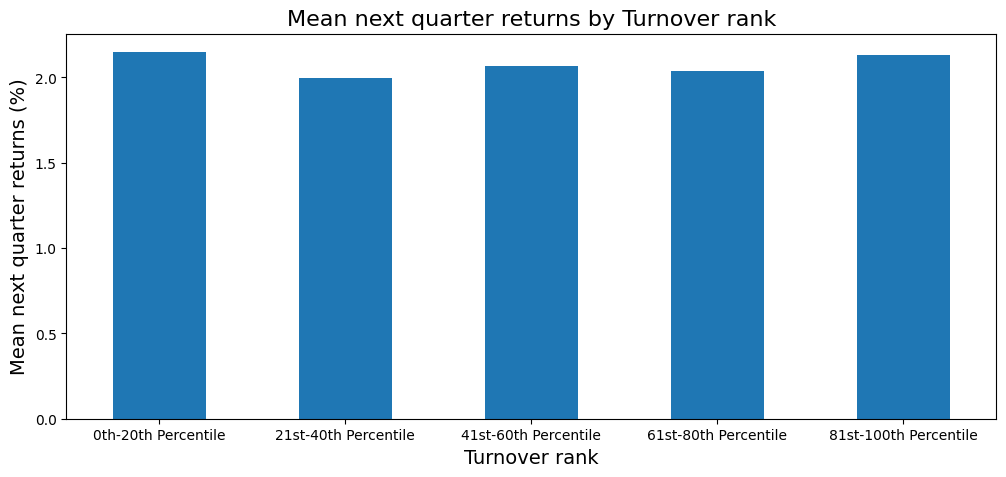

In [154]:
# Barplot based on category of turnover ratio  
# Turnover does not have clear relationship with future performance
tmp = train_subfund_features.copy()
tmp["turnover_ratio_rank"] = tmp.groupby("date_holding")["avg_turnover_ratio"].rank(pct=True)
tmp["turnover_ratio_group"] = tmp["turnover_ratio_rank"].apply(lambda x: int(x/0.2)).clip(upper=4)
plt.figure(figsize=(12,5))
(tmp.groupby('turnover_ratio_group')["next_quarter_return"].mean()*100).plot(kind="bar")
plt.title("Mean next quarter returns by Turnover rank",fontsize=16)
plt.xlabel("Turnover rank",fontsize=14)
plt.ylabel("Mean next quarter returns (%)",fontsize=14)
plt.xticks(np.arange(5),labels=["0th-20th Percentile",
                                "21st-40th Percentile",
                                "41st-60th Percentile",
                                "61st-80th Percentile",
                                "81st-100th Percentile"], rotation=0)
print()

<AxesSubplot: >

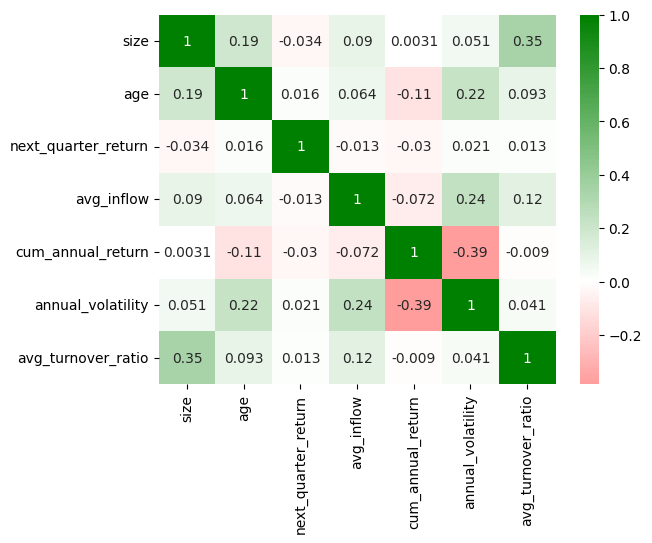

In [576]:
# Fund volatility negatively correlated with historical returns
# Turnover ratio positively correlated with size

from matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
sns.heatmap(train_subfund_features.corr(method="spearman"), annot=True, cmap=cmap, center=0)

<AxesSubplot: >

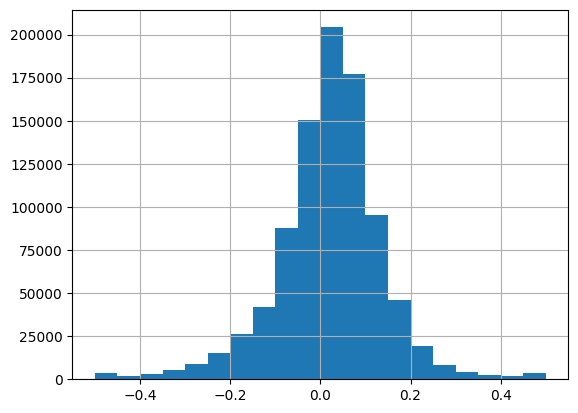

In [577]:
# Will splitting by subfund show a different distribution or different insights?
train_subfund_features.next_quarter_return.clip(lower=-0.5,upper=0.5).hist(bins=20)

# Sample Fund Analysis

In [159]:
sample_analysis = train_fund_features.copy()
sample_analysis["size_rank"] = sample_analysis.groupby("date_holding")["size"].rank(pct=True)
sample_analysis["size_group"] = sample_analysis["size_rank"].apply(lambda x: int(x/0.2)).clip(upper=4)
sample_analysis["age_rank"] = sample_analysis.groupby("date_holding")["age"].rank(pct=True)
sample_analysis["age_group"] = sample_analysis["age_rank"].apply(lambda x: int(x/0.2)).clip(upper=4)
sample_analysis["inflow_rank"] = sample_analysis.groupby("date_holding")["avg_inflow"].rank(pct=True)
sample_analysis["inflow_group"] = sample_analysis["inflow_rank"].apply(lambda x: int(x/0.2)).clip(upper=4)
sample_analysis["return_rank"] = sample_analysis.groupby("date_holding")["cum_annual_return"].rank(pct=True)
sample_analysis["return_group"] = sample_analysis["return_rank"].apply(lambda x: int(x/0.2)).clip(upper=4)
sample_analysis["vol_rank"] = sample_analysis.groupby("date_holding")["annual_volatility"].rank(pct=True)
sample_analysis["vol_group"] = sample_analysis["vol_rank"].apply(lambda x: int(x/0.2)).clip(upper=4)
sample_analysis["turnover_ratio_rank"] = sample_analysis.groupby('date_holding')["avg_turnover_ratio"].rank(pct=True)
sample_analysis["turnover_ratio_group"] = sample_analysis["turnover_ratio_rank"].apply(lambda x: int(x/0.2)).clip(upper=4)
sample_analysis = sample_analysis[["age_group", "return_group", "vol_group", "size_group", "inflow_group", "turnover_ratio_group"]]
sample_analysis.columns = ["Age Quintile", "Historical Performance Quintile", "Historical Volatility Quintile",
                          "Size Quintile", "Inflow Quintile", "Turnover Quintile"]
sample_analysis = sample_analysis + 1

In [175]:
# HFT - Virtu Financial
sample_analysis.xs(1533964, level=1).loc["2017-01-01":"2018-09-30"]

,Age Quintile,Historical Performance Quintile,Historical Volatility Quintile,Size Quintile,Inflow Quintile,Turnover Quintile
date_holding,,,,,,
2017-03-31,3,3,4,1,3,5
2017-06-30,3,3,4,1,2,5
2017-12-31,3,3,4,5,1,5
2018-03-31,3,1,5,5,1,5
2018-06-30,3,1,5,3,1,5
2018-09-30,3,1,5,5,1,5


In [171]:
# HFT - Jane Street
sample_analysis.xs(1595888, level=1).loc["2017-01-01":"2018-09-30"]

,Age Quintile,Historical Performance Quintile,Historical Volatility Quintile,Size Quintile,Inflow Quintile,Turnover Quintile
date_holding,,,,,,
2017-03-31,1,1,4,5,5,5
2017-06-30,1,1,5,5,5,5
2017-09-30,2,1,5,5,5,5
2018-03-31,2,1,5,5,5,5
2018-09-30,2,1,5,5,5,5


In [170]:
# Quant fund - D.E Shaw
sample_analysis.xs(1009207, level=1).loc["2017-01-01":"2018-09-30"]

,Age Quintile,Historical Performance Quintile,Historical Volatility Quintile,Size Quintile,Inflow Quintile,Turnover Quintile
date_holding,,,,,,
2017-03-31,4,1,5,5,4,5
2017-06-30,4,1,5,5,4,5
2017-09-30,4,1,5,5,4,5
2017-12-31,4,1,5,5,4,5
2018-03-31,4,1,5,5,4,5
2018-06-30,4,1,5,5,4,5
2018-09-30,4,1,5,5,4,5


In [174]:
# Quant fund - Rentech
sample_analysis.xs(1037389, level=1).loc["2017-01-01":"2018-09-30"]

,Age Quintile,Historical Performance Quintile,Historical Volatility Quintile,Size Quintile,Inflow Quintile,Turnover Quintile
date_holding,,,,,,
2017-03-31,5,1,5,5,5,3
2017-06-30,5,1,5,5,5,3
2017-09-30,5,1,5,5,5,4
2017-12-31,5,1,5,5,5,4
2018-03-31,5,1,5,5,5,4
2018-06-30,5,1,5,5,5,4
2018-09-30,5,1,5,5,5,4


In [172]:
# Asset Management - Bridgewater
sample_analysis.xs(1350694, level=1).loc["2017-01-01":"2018-09-30"]

,Age Quintile,Historical Performance Quintile,Historical Volatility Quintile,Size Quintile,Inflow Quintile,Turnover Quintile
date_holding,,,,,,
2017-03-31,4,5,3,4,3,5
2017-06-30,4,4,3,4,3,5
2017-09-30,4,4,3,4,3,5
2017-12-31,4,4,3,4,3,5
2018-03-31,4,4,3,4,3,5
2018-06-30,4,4,3,4,3,5
2018-09-30,4,4,3,4,3,5


In [173]:
# Pension fund - National Pension Service (KR, 3rd largest in the world)
sample_analysis.xs(1608046, level=1).loc["2017-01-01":"2018-09-30"]

,Age Quintile,Historical Performance Quintile,Historical Volatility Quintile,Size Quintile,Inflow Quintile,Turnover Quintile
date_holding,,,,,,
2017-03-31,1,4,1,5,4,1
2017-06-30,1,4,1,5,4,1
2017-09-30,1,4,1,5,4,1
2017-12-31,1,4,1,5,4,1
2018-03-31,2,4,1,5,4,1
2018-06-30,2,4,1,5,3,1
